In [1]:
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import heapq # for retrieval topK
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
import json
from datetime import datetime
from pprint import pprint 
from time import time
from scipy.sparse.linalg import svds, eigs
%matplotlib inline

# Load in log data and clean it 

In [2]:
for root,dirs,files in os.walk('.'):
    pprint(files)
    file_list = files
df_etu_log = pd.read_csv('etu_log.csv', engine = 'python',error_bad_lines=False)

['Negative_test_rating_19N.txt',
 'etu_log.csv',
 'Hybrid.ipynb',
 'Content-based.ipynb',
 'Negative_test_rating_199N.txt',
 'README.md',
 'doc2_conversion_table.csv',
 'cw-article.csv',
 'doc1_viewing_columnExp.csv',
 'doc1_viewing_history_cateID.csv',
 'article_contents.csv',
 'doc3_post_and_clicks.csv',
 'DailyPost.csv',
 'Negative_test_rating_50N.txt',
 'EDA.ipynb',
 'doc2_conversion_reference.csv',
 'CF.ipynb',
 'Negative_test_rating_99N.txt',
 'doc1_viewing_data.csv']
['output.json',
 'optimization_test.py',
 'output_untuned.json',
 'multilingual.md',
 'LICENSE',
 'bert_train_data.ipynb',
 'input.txt',
 'tokenization.py',
 'create_pretraining_data.py',
 'README.md',
 'optimization.py',
 'run_pretraining.py',
 'extract_features.py',
 'requirements.txt',
 'tokenization_test.py',
 'chinese_L-12_H-768_A-12.zip',
 'run_classifier.py',
 'run_squad.py',
 'sample_text.txt',
 'bert_dev.p',
 '__init__.py',
 'run_classifier_with_tfhub.py',
 'CONTRIBUTING.md',
 'bert_train.p',
 'modeling.py'

Skipping line 4359075: unexpected end of data


In [3]:
df_etu_log.head()

,time,act,cat,pid,eruid,keywords,url,hostname,agent,predn,preurl,lo,ssid,paywall,dates,eturec
0,00:00:02,view,79.0,5088277.0,375b2a4d-6b06-c1aa-1cf6-a9472e820d65,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (Linux; Android 6.0.1; HTC_D10u Bu...,m.facebook.com,http://m.facebook.com/,0.0,8fa8df160d30,NaN,2018-02-18,NaN
1,00:00:01,view,11.0,5087710.0,1be09de3-2363-1350-b095-221d37445280,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_5 like...,m.facebook.com,http://m.facebook.com,0.0,c0430e760562,NaN,2018-02-18,NaN
2,00:00:02,view,85.0,5088005.0,ced1cce8-08cc-0e84-82ec-b1b1ce6f32a0,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...,m.facebook.com,http://m.facebook.com,0.0,eed333bf3ef0,NaN,2018-02-18,NaN
3,00:00:02,view,11.0,5088180.0,bde6bba0-bd52-e4b3-a17b-18cd72b02214,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_5 like...,m.facebook.com,http://m.facebook.com,0.0,bb8b100b1fad,NaN,2018-02-18,NaN
4,00:00:01,view,7.0,5081463.0,bb652779-3133-e1ec-5914-24d902b70197,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (Linux; Android 6.0.1; CPH1611 Bui...,www.google.com.tw,https://www.google.com.tw/,0.0,228acfd7c345,NaN,2018-02-18,NaN


In [4]:
def del_df_columns_list(df,column_name,name_list,way_is_1=True):
    
    """
    it can only delete one columns once 
    """
    if way_is_1 == True:
        for i in name_list:
            df = df[df[column_name] != i]
    else:
    #     below is the pd.merge way to merge data, but sometime coz pd will mislead the columns due to dtypes
    #     If using the merge way, we should get the list that we want to PERSERVE.    
        d = pd.DataFrame(data = name_list, columns = [column_name])
        df = pd.merge(df, d, how = 'inner', on = [column_name])
    
    return df




print('start preprocessing')
### Delete the unique user with click time less than 2, for 1 clicking user for CF-model is useless
del_list = df_etu_log.eruid.value_counts()[(df_etu_log.eruid.value_counts() > 2) & (df_etu_log.eruid.value_counts() < 90*50)].keys()
df_etu_log = del_df_columns_list(df_etu_log,'eruid',del_list,way_is_1 = False)
print('Done_1,df_shape is :',df_etu_log.shape)
### Drop the na-value in pid,eruid
df_etu_log = df_etu_log.dropna(subset = ['pid','eruid'],how = 'any')
print('Done_2,df_shape is :',df_etu_log.shape)
### The time format should be like '**-**-**', so we filter out those length not equal to 8.
del_list = list(set([i for i in df_etu_log.time if len(i)!=8])) 
df_etu_log = del_df_columns_list(df_etu_log,'time',del_list)
print('Done_3,df_shape is :',df_etu_log.shape)
### Creating the column using both time and date
df_etu_log['datetime'] = df_etu_log['dates'] +'-'+ df_etu_log['time']
print('Done_4,df_shape is :',df_etu_log.shape)

start preprocessing
Done_1,df_shape is : (2154549, 16)
Done_2,df_shape is : (1993796, 16)
Done_3,df_shape is : (1993796, 16)
Done_4,df_shape is : (1993796, 17)


# Load in content related data

In [5]:
### clean content info
df_content = pd.read_csv('article_contents.csv').drop(columns = ['Unnamed: 0'])
df_cate = pd.read_csv('cw-article.csv').rename({'id':'pid'},axis = 'columns')
### about 300 articles have mutiple class, not a huge number, but if we want to improve the performance of classifer, it might be better to use a ML to re-classify the labels
### we keep the first class only here
df_cate = pd.DataFrame.drop_duplicates(df_cate , subset = 'pid',keep = 'first')

### merge the content info
df_content = pd.merge(df_content,df_cate[['pid','author','type','masterChannelTitle','onlineTime']],how = 'left',on = 'pid')
### To fine-tune the bert, all data must have label, so around 200 article are without labels, drop them first.
df_content = df_content.dropna(axis = 0,subset = ['masterChannelTitle'] )

### cleaning the sentences and remove pattern like <p>, </p>, etc..
df_content['文章內容'] = df_content['文章內容'].str.replace('<.*?>','')
df_content['文章內容'] = df_content['文章內容'].str.replace('\r|&[a-z]','')
df_content['文章內容'] = df_content['文章內容'].replace('',np.nan)
list_content_empty = []
pid_content_empty = []
for i in range(len(df_content)):
    if type(df_content.iloc[i,2]) is not str:
        pid_content_empty.append(df_content.iloc[i,0])
        list_content_empty.append(df_content.index[i])
df_content.drop(list_content_empty, inplace = True)

### label-encode the master channel to make it compatible to bert fine-tune config.
cate_dict = {
    '教育':0,
    '產業':1, 
    '財經時事':2,
    '經營管理':3, 
    '政治社會':4, 
    '經濟學人':5, 
    '環境':6, 
    '人物觀點':7,
    '專欄':8,
    '國際':9, 
    '健康關係':10, 
    '時尚生活':11, 
    '調查':12, 
    '數據圖表':13,
    '天下雜誌部落格':14, 
    '互動圖表':15, 
    '@想像未來':16,
    '天下Talk':17}
df_content['cate_label'] = df_content.apply(lambda w:cate_dict[w.masterChannelTitle],axis = 1)

print(df_content.shape)

(45686, 8)


In [6]:
### load in bert vector
bert_vector = []
with open('bert_vector/output.json') as file:
    for line in file.readlines():
        bert_vector.append(json.loads(line))
        
df_content = df_content.reset_index().join(pd.DataFrame(bert_vector).features)

In [7]:
### create pid-vector dictionary
pid_vector = {}
for i in range(len(df_content)):
    pid_vector[df_content['pid'].values[i]] = df_content['features'].values[i]

# Metrics Definition

In [8]:
### Hit rate / NDCG
### reference : https://www.comp.nus.edu.sg/~xiangnan/papers/cikm15-trirank-cr.pdf

def getHitRatio(ranklist, gtItem):
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    ar = np.array(ranklist)
    if gtItem in ar:
        return math.log(2) / math.log(np.where(ar == gtItem)[0][0] + 2)
    return 0

In [9]:
def eval_one_rating(idx, eval_mode, uim, pid_vector,test_user_last_pid):
    
    '''''
    eval_mode = 'Keras', 'ALS', 'matrix'
    '''''
    rating = _testRatings[idx]
    ### rating should be like (  [user_id,article_pid(only one article, which is ground truth)]  ) 
    items = _testNegatives[idx][1]
    ### items should be like (  [article_pid(199 ones, which are ones the reader haven't read)]  )
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    
    # Get prediction scores, the process is we offer 100(99 negative + 1 ground truth) articles to one user in testing data, and predict the score(read or not) and ranking.
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')

    if eval_mode == 'ALS':
        predictions = _model.rank_items(u, uim.T, items)
        items.pop()
        ranklist = np.array(predictions, dtype = int)[:_K,0]
        
    else:
        if eval_mode == 'Keras':
            predictions = _model.predict([users,
                                          np.array(items)], 
                                         batch_size=100, verbose=0)
        elif eval_mode == 'matrix':         
            predictions = _model[u,items]
        

        for i in range(len(items)):
            item = items[i]
            map_item_score[item] = predictions[i]
        items.pop()
        
        # Evaluate top rank list
        ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
        
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

In [10]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread, eval_mode = 'Keras', uim = None,
                   pid_vector = None, test_user_last_pid = None):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs = [],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return (hits, ndcgs)
    else:# Single thread
        for idx in range(len(_testRatings)):
            (hr,ndcg) = eval_one_rating(idx, eval_mode, uim, pid_vector, test_user_last_pid)
            hits.append(hr)
            ndcgs.append(ndcg)      
    return (hits, ndcgs)

# Training Testing Split

#### In this section, I hope that I don't just randomly split the training/testing sets into 9:1.
#### Rather, I will select those users with over 5 click times and pick the last click as the testing set.
#### For example, index 1354 user has following reading history:{2,364,8796,4511,5,64}.
#### This user history for {2,364,8796,4511,5} will be viewed as training set and 64 will be testing.
#### Here testing means 1354 user did click into the article 64, and If the recommendation system provides the article in the recommending list, it means it succeed.

In [11]:
def train_test_split_time(df , columns_1 , columns_2 , columns_time , ratio = 0.9):
    '''
    we will use the columns_1 as the first level index
    sort the columns_2 as the target by columns_time
    '''
    
    retreive_name = df[columns_1].value_counts()[df[columns_1].value_counts()>5].keys()
    df_test = df[df[columns_1].isin(retreive_name)]
    df_test = df_test.sort_values(columns_time).groupby(columns_1).tail(1)
    df_train = df.drop(index=df_test.index)
        
    if df_test.shape[0] + df_train.shape[0] == df.shape[0]:
        print('train_test_split succeed!! with df_train shape:(%d,%d), df_test shape:(%d,%d)'
              %(df_train.shape[0],df_train.shape[1],df_test.shape[0],df_test.shape[1])
             )
        return df_train, df_test, retreive_name
    else:
        print('Oops, something wrong, with df_train shape : (%d,%d), df_test shape : (%d,%d)'
              %(df_train.shape[0],df_train.shape[1],df_test.shape[0],df_test.shape[1])
             )
        print('df_shape : (%d,%d)'
              %(df.shape[0],df.shape[1])
             )

In [12]:
df_train,df_test, retrieve = train_test_split_time(df_etu_log,'eruid','pid','datetime')

train_test_split succeed!! with df_train shape:(1894191,17), df_test shape:(99605,17)


#### We will use the leave-one-out method to evaluate our testing data
#### Basically, we will generate N samples list that the test user hasn't read and add the ground truth into the list, and see how the recommendation system will score and rank the list

In [13]:
def get_sampling(df_target,df_source,numbers_of_N_sample, generate_negative = False):
    '''
    1.
    return: test_rating in the shape of [ [user_pid,article] *99605 ]
    2.
    from the target dataframe, sampling the negative sample from source dataframe
    return: list in the shape of [ [(2(user_id,ground truth)) , [19(negative samples)] ]*99605]
    '''
    
    test_rating = df_target[['eruid','pid']].values.tolist()
    
    print('test_rating yield successfully!!!')
    
    if generate_negative == True:
        df_temp = df_source.drop_duplicates(subset = 'pid', keep = 'first')
        negative_test_rating = []
        for i in range(df_target.shape[0]):
            drop_id = test_rating[i][0]
            list_ = df_temp[df_temp['eruid'] != drop_id]['pid'].sample(numbers_of_N_sample).values.tolist()
            
            negative_test_rating.append([test_rating[i],list_])
        print('negative_test_rating yield successfully!!!')

        return test_rating, negative_test_rating
    else:
        return test_rating

In [14]:
print('''only for generating sample, if there is a sample file already, skip this cell in the future''')
### In the future just execute the next cell to get the test rating & negative sampling
    
### Experiment on my theory: whether the N samples in hit ratio is a parameters that needs to tune
# time1 = time()
# test_rating, negative_test_rating = get_sampling(df_test,df_train,199,True)
# time2 = time()
# print('Took for %d seconds' %(time2-time1))
# with open("Negative_test_rating_199N.txt","wb") as f: #in write mode
#     pickle.dump(negative_test_rating,f)
    

only for generating sample, if there is a sample file already, skip this cell in the future


In [15]:
time1 = time()
test_rating = get_sampling(df_test,df_train,None)
with open("Negative_test_rating_199N.txt",'rb') as f: #in read mode, not in write mode, careful
    negative_test_rating = pickle.load(f)
    print('negative_test_rating yield successfully!!!')
time2 = time()
print('Took for %d seconds' %(time2-time1))

test_rating yield successfully!!!
negative_test_rating yield successfully!!!
Took for 4 seconds


# Keras Hybrid Recommendation system

In [16]:
### In this part, we will first make the matrix to be like 1 for read once 0 for never-read 
df_train['read_time'] = 1
df_test['read_time'] = 1
df_train_group = df_train[['eruid','pid','read_time']].groupby(by = ['eruid','pid'],as_index=False).sum()
df_test_group = df_test[['eruid','pid','read_time']].groupby(by = ['eruid','pid'],as_index=False).sum()

### For the reason that normally people don't read articles more than 10 times
cliper = 10
df_train_group['read_time'] = df_train_group['read_time'].apply(lambda w: min(cliper,w))


### To feed into the keras model, we have to turn both the eruid and pid into integer index
eruid_map = {i:v for i,v in enumerate(df_etu_log.eruid.unique())}
inverse_eruid_map = {v:i for i,v in enumerate(df_etu_log.eruid.unique())}
pid_map = {i:v for i,v in enumerate(df_etu_log.pid.unique())}
inverse_pid_map = {v:i for i,v in enumerate(df_etu_log.pid.unique())}

In [17]:
df_train_group.head()

,eruid,pid,read_time
0,00002400-4800-5264-2ee9-bd655a0a91cd,5082394.0,1
1,00002400-4800-5264-2ee9-bd655a0a91cd,5087575.0,1
2,00003620-4c40-2906-33ad-26cb9d5fe178,5053327.0,1
3,00003620-4c40-2906-33ad-26cb9d5fe178,5055570.0,1
4,00003620-4c40-2906-33ad-26cb9d5fe178,5068161.0,1


In [30]:
### creating a mapping table for training data
df_train_group_map = df_train_group.copy()
df_test_group_map = df_test_group.copy()
df_train_group_map['eruid'] = df_train_group['eruid'].map(inverse_eruid_map)
df_train_group_map['pid'] = df_train_group['pid'].map(inverse_pid_map)
df_test_group_map['eruid'] = df_test_group['eruid'].map(inverse_eruid_map)
df_test_group_map['pid'] = df_test_group['pid'].map(inverse_pid_map)

### creating a mapping list for testing data   
test_rating_map = []
for i in range(len(test_rating)):
    test_rating_map.append([inverse_eruid_map[test_rating[i][0]],inverse_pid_map[test_rating[i][1]]])


### creating a mapping list for negative testing data
negative_test_rating_map = []
for i in range(len(negative_test_rating)):
    negative_test_rating_map.append([
                                     [inverse_eruid_map[negative_test_rating[i][0][0]],inverse_pid_map[negative_test_rating[i][0][1]]],
                                     list(map(lambda w:inverse_pid_map[w],negative_test_rating[i][1]))])

    
### append negative sample into df_training_map
np.random.seed(2019)
negative_training_size = 50 * df_train_group_map.shape[0]
ng_eruid = np.random.randint(low = 0,high = max(eruid_map.keys()), size = negative_training_size)
ng_pid = np.random.randint(low = 0, high = max(pid_map.keys()), size = negative_training_size)
df_ngt = pd.DataFrame(columns=['eruid','pid','read_time'],
                      data=np.array([ng_eruid,ng_pid,[0]*negative_training_size]).T)
df_train_group_map.drop_duplicates(subset=['eruid','pid'],keep = 'first')
df_train_group_map = df_train_group_map.append(df_ngt , ignore_index=True).reset_index()


In [31]:
print('df_train_group_map shape: ',df_train_group_map.shape)
print('number of users: ', len(eruid_map.items()))
print('number of items: ', len(pid_map.items()))
print('The sparse matrix is one with shape (%d , %d), with %d zero & non-zero read_times'
      %(len(eruid_map.items()),len(pid_map.items()),df_train_group_map.shape[0]))


df_train_group_map shape:  (79305102, 4)
number of users:  368598
number of items:  19988
The sparse matrix is one with shape (368598 , 19988), with 79305102 zero & non-zero read_times


In [32]:
from keras.models import Model
from keras.layers import Embedding, Input, Dense, merge, Reshape, Concatenate, Flatten,multiply, subtract, Dot
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import Multiply, multiply, Concatenate
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.regularizers import l2
from keras import initializers
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adadelta
from keras import backend as K

In [33]:
num_items = len(pid_map.items())
### Try create embedding matrix
pid_vector_create = pid_vector.copy()
pid_vector_create[-1] = [0] * 3072
pid_map_vector = {(inverse_pid_map[k] if k in inverse_pid_map else -1): v  for k, v in pid_vector_create.items()}
pid_map_vector.pop(-1)
print(len(pid_map_vector))
input_len = 3072
embedding_matrix = np.zeros((num_items, input_len), dtype=np.float32)
for i in pid_map_vector.keys():
    embedding_matrix[i] = np.array(pid_map_vector[i][:input_len])

bert_embedding_layer = Embedding(num_items,
                            input_len,
                            weights=[embedding_matrix],
                            name = 'BERT_embedding_vector',
                            trainable=False)



19914


In [34]:
def init_normal(shape,name=None):
    return initializers.VarianceScaling(scale=0.01, mode='fan_in', distribution='normal')(shape)

def get_model(num_users, num_items, latent_dim, embedding_layer, regs=[0,0]):
    
    ''' Deep part : user-item-log embedding part '''
    ### define placeholder.
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    ### define embedding size and layers.

    user_embedding = Embedding(output_dim = latent_dim, input_dim = num_users,
                               input_length=1, name='user_embedding',
                               embeddings_regularizer = l2(regs[0]),
                               embeddings_initializer = init_normal)(user_id_input)
    item_embedding = Embedding(output_dim = latent_dim, input_dim = num_items,
                               input_length=1, name='item_embedding',
                               embeddings_regularizer = l2(regs[1]),
                               embeddings_initializer = init_normal)(item_id_input)

    user_vecs = Reshape([latent_dim])(user_embedding)
    item_vecs = Reshape([latent_dim])(item_embedding)
    
    mf = multiply([user_vecs, item_vecs])

    ''' Wide part : item embedding vector part '''
    ### input extracted matrix(here use embedding) and concatenate with one single DNN layer 
    item_vector = Flatten()(embedding_layer(item_id_input))
    item_vector_dense = Dense(768, activation='relu')(item_vector)

    
    
    '''Concatenate the deep and wide part'''
    
    concate_vector = Concatenate()([mf,
                                    item_vector_dense,
                                   ])
    
    ### The prediction, which we calculate the loss function with ground truth and optimize.
    y_hat =Dense(1, activation='selu',kernel_initializer='lecun_uniform', name = 'prediction')(concate_vector)
    
    
    model = Model(inputs=[user_id_input, item_id_input], outputs=y_hat)
    
    return model

In [35]:
num_users = len(eruid_map.items())
num_items = len(pid_map.items())
topK = 5
verbose = 0
latent_dim = 15
epochs = 100
batch_size = 4096
evaluation_threads = 1
best_hr, best_ndcg, best_iter = -1, -1, -1
model_out_file = 'models/GMF_%d_%d.h5' %(latent_dim, time())
testRatings, testNegatives = test_rating_map, negative_test_rating_map
learning_rate = 0.001
model = get_model(num_users, num_items, latent_dim, bert_embedding_layer , regs=[0,0])
model.compile(optimizer=Adam(lr=learning_rate), loss='mse') ### In this task, for label is 'read times'(integers from 0 -> 3XXX), so we use MSE as loss to optimize,
                                                            ### However, if there is 'read or not-read'(integers 0 and 1), we should use 'binary cross-entropy'
                                                            ### P.S. If using 'binary cross-entropy' in 'read times' task, I get the weird result with negative l
hr_list = []
loss_list = []
patience = 5
early_stop =True


# Generate training instances
user_input, item_input = df_train_group_map.eruid, df_train_group_map.pid
labels = df_train_group_map.read_time

print('start training...')
for epoch in range(epochs):
    t1 = time()
    print('training for the %d epoch' % (epoch))    
    # Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size = batch_size,
                         validation_data = ( [df_test_group_map.eruid,df_test_group_map.pid]                                            
                                            ,df_test_group_map.read_time) ,
                         epochs = 1, verbose = verbose, shuffle = True)
    t2 = time()

    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads,pid_vector=pid_vector)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['val_loss'][0]    
    hr_list.append(hr)
    loss_list.append(loss)
    # Using patience to set the early stopping.
    # Always to save the model with minimun loss.
    if hr < np.max(hr_list):
        patience_count += 1
    else:
        patience_count = 0
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        model.save_weights(model_out_file, overwrite=True)
    if (early_stop) and (patience_count == patience):
        break
    if epoch % 1 == 0:
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, val_loss = %.4f [%.1f s]' 
            % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))

print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))

start training...
training for the 0 epoch
Iteration 0 [206.2 s]: HR = 0.6515, NDCG = 0.4656, val_loss = 0.4454 [163.4 s]
training for the 1 epoch
Iteration 1 [206.0 s]: HR = 0.6875, NDCG = 0.4949, val_loss = 0.4047 [164.4 s]
training for the 2 epoch
Iteration 2 [206.4 s]: HR = 0.6808, NDCG = 0.4919, val_loss = 0.3926 [162.8 s]
training for the 3 epoch
Iteration 3 [206.0 s]: HR = 0.6699, NDCG = 0.4839, val_loss = 0.3988 [162.9 s]
training for the 4 epoch
Iteration 4 [206.1 s]: HR = 0.6614, NDCG = 0.4765, val_loss = 0.4073 [162.3 s]
training for the 5 epoch
Iteration 5 [206.5 s]: HR = 0.6532, NDCG = 0.4697, val_loss = 0.4163 [162.3 s]
training for the 6 epoch
End. Best Iteration 1:  HR = 0.6875, NDCG = 0.4949. 


In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 15)        5528970     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 15)        299820      item[0][0]                       
__________________________________________________________________________________________________
BERT_embed

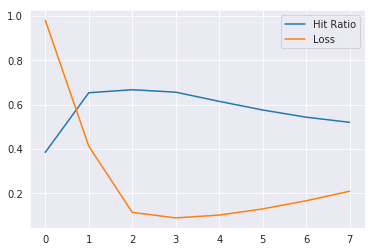

In [19]:
sns.set_style('darkgrid')
plt.plot(hr_list, label = 'Hit Ratio')
plt.plot(loss_list, label = 'Loss')
plt.legend()